# Car Price Prediction using Regression

### Import necessary libraries

In [1]:
import pandas as pd #dataframe
import numpy as np #mathematical computations
import matplotlib.pyplot as plt #visualization
import matplotlib
import seaborn as sns #visualization
import json #exporting columns
import pickle #saving the model
from sklearn.linear_model import LinearRegression #Linear Regression
from sklearn.linear_model import Lasso #Lasso Regression
from sklearn.tree import DecisionTreeRegressor #Decision Tree Regression
from sklearn.ensemble import RandomForestRegressor #Random Forest Regression
from sklearn.model_selection import train_test_split #Splitting the dataset into training and testing
from sklearn.model_selection import ShuffleSplit #Random shuffling
from sklearn.model_selection import cross_val_score #Score cross validation
from sklearn.model_selection import GridSearchCV #Hyper parameter tuning
from warnings import simplefilter #Filtering warnings

simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

### Load data into DataFrame

In [2]:
df1 = pd.read_csv('car-dataset.csv')
df1.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [3]:
# shape
df1.shape

(4340, 8)

In [4]:
# data columns
df1.columns

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner'],
      dtype='object')

### Dropping feature that is not required in building our model

In [5]:
# I also consider reindexing the columns, putting the dependent variable at the end
# Dropping the name of the car and seller type
# Retained the columns transmission,number of previous owner, fuel, year and kilometer driven for these features might greatly affect the selling price

df2 = df1.drop(['name','seller_type'],axis=1).reindex(['transmission','fuel','owner','year','km_driven','selling_price'],axis=1)
df2.head()

,transmission,fuel,owner,year,km_driven,selling_price
0,Manual,Petrol,First Owner,2007,70000,60000
1,Manual,Petrol,First Owner,2007,50000,135000
2,Manual,Diesel,First Owner,2012,100000,600000
3,Manual,Petrol,First Owner,2017,46000,250000
4,Manual,Diesel,Second Owner,2014,141000,450000


### Check for null values

In [6]:
# method 1
df2.isnull().sum()

transmission     0
fuel             0
owner            0
year             0
km_driven        0
selling_price    0
dtype: int64

In [7]:
# method 2
df2.isnull().any()

transmission     False
fuel             False
owner            False
year             False
km_driven        False
selling_price    False
dtype: bool

### Check for data consistency

<div style="background-color: #303030;padding: 20px;font-size: 16px;color:white;">
You might want to check the integrity of the data whether the columns contains mispelled data or that data pertains to same idea.
</div>

In [8]:
df2.transmission.unique()

array(['Manual', 'Automatic'], dtype=object)

In [9]:
df2.fuel.unique()

array(['Petrol', 'Diesel', 'CNG', 'LPG', 'Electric'], dtype=object)

In [10]:
df2.year.unique()

array([2007, 2012, 2017, 2014, 2016, 2015, 2018, 2019, 2013, 2011, 2010,
       2009, 2006, 1996, 2005, 2008, 2004, 1998, 2003, 2002, 2020, 2000,
       1999, 2001, 1995, 1997, 1992], dtype=int64)

### Adding new feature

In [11]:
# adding a converted price for philippine peso

df2['selling_price_peso'] = round(df2['selling_price'] * 0.65,2)

# dropping selling price in rupees

df3 = df2.drop('selling_price',axis=1)
df3.head()

,transmission,fuel,owner,year,km_driven,selling_price_peso
0,Manual,Petrol,First Owner,2007,70000,39000.0
1,Manual,Petrol,First Owner,2007,50000,87750.0
2,Manual,Diesel,First Owner,2012,100000,390000.0
3,Manual,Petrol,First Owner,2017,46000,162500.0
4,Manual,Diesel,Second Owner,2014,141000,292500.0


<div style="background-color: #303030;padding: 20px;font-size: 16px;color:white;">
Let see the data distribution based on each features.
</div>

### Exploratory Data Analysis

### Manual and Automatic Cars

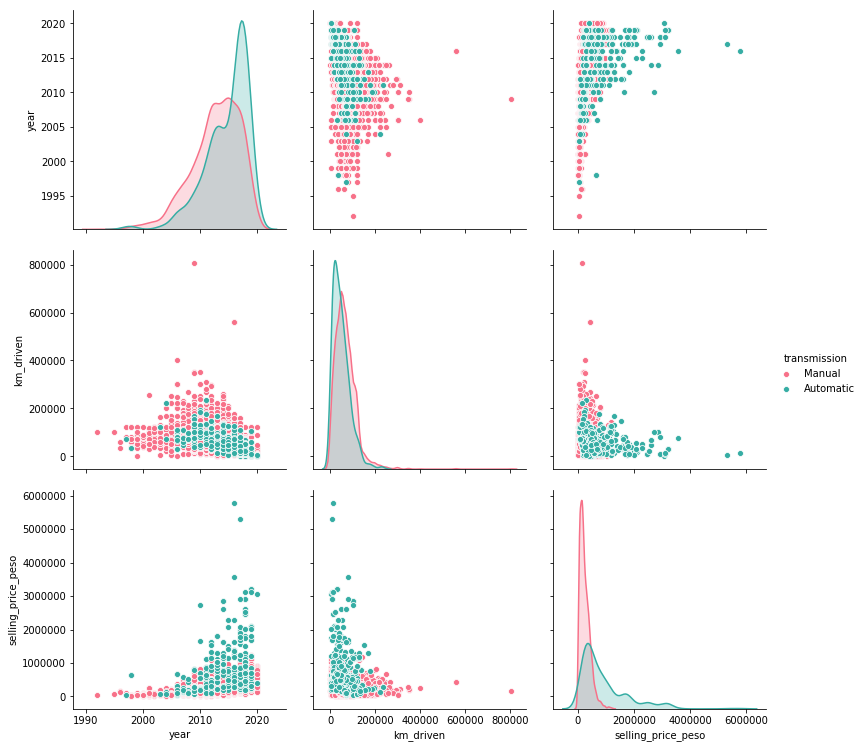

In [12]:
sns.pairplot(df3,hue = 'transmission',diag_kind = "kde",kind = "scatter",palette = "husl",height=3.5)
plt.show()

<div style="background-color: #303030;padding: 20px;font-size: 16px;color:white;">
    We can see that automatic cars have higher price range than manual type cars though the distribution of automatic cars were skewed to the right. We can also see the increase of automatic cars between 2015 and 2020. In this instance, we can clearly see some outliers in selling price and kilometers driven.
</div>

### Fuel types

In [13]:
df3['fuel'].value_counts()

Diesel      2153
Petrol      2123
CNG           40
LPG           23
Electric       1
Name: fuel, dtype: int64

<div style="background-color: #303030;padding: 20px;font-size: 16px;color:white;">
Since most of the data points are Diesel and Petrol, we can label other fuel types as Others.
</div>

In [14]:
df4 = df3
df4.fuel = df4.fuel.map(lambda x: x if x in ['Diesel','Petrol'] else 'Other')
df4.fuel.unique()

array(['Petrol', 'Diesel', 'Other'], dtype=object)

In [15]:
manual = df4[df4['transmission']=='Manual']
automatic = df4[df4['transmission']=='Automatic']

Manual type car


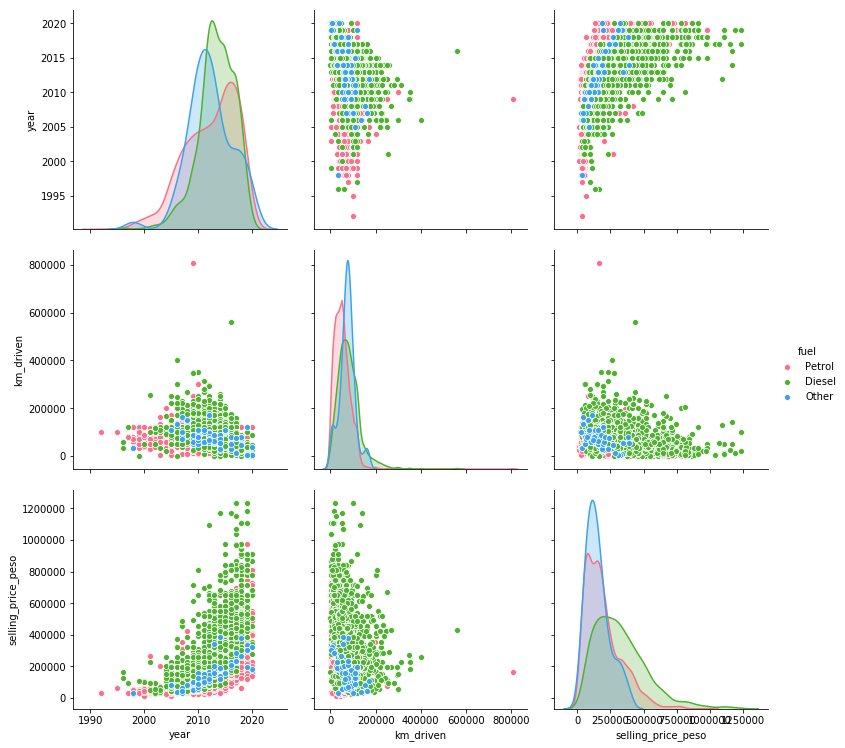

In [16]:
print('Manual type car')
sns.pairplot(manual,hue = 'fuel',diag_kind = "kde",kind = "scatter",palette = "husl",height=3.5)
plt.show()

Automatic type car


C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


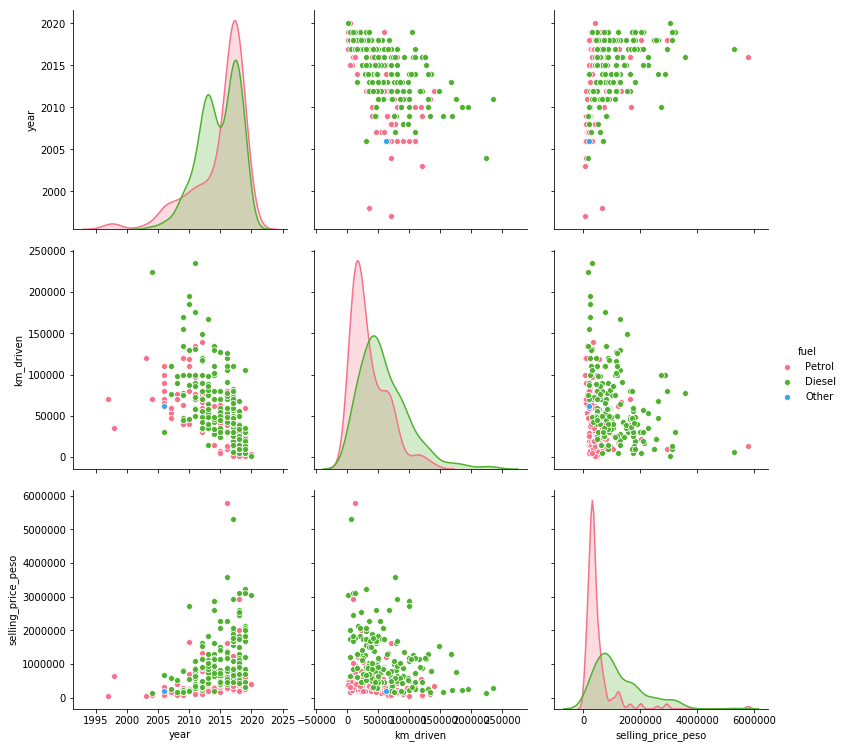

In [17]:
print('Automatic type car')
sns.pairplot(automatic,hue = 'fuel',diag_kind = "kde",kind = "scatter",palette = "husl",height=3.5)
plt.show()

<div style="background-color: #303030;padding: 20px;font-size: 16px;color:white;">
    We can see that the selling price of diesel type cars in both manual and automatic were more spread than petrol and other fuel hence getting higher average and range of selling price.
</div>

### Owner

In [18]:
df4.groupby('owner')[['km_driven','selling_price_peso']].agg(['count','mean']).applymap(lambda x: format(x,'.0f'))

km_driven        selling_price_peso        
                         count   mean              count    mean
owner                                                           
First Owner               2832  56015               2832  389114
Fourth & Above Owner        81  99138                 81  113036
Second Owner              1106  81784               1106  223529
Test Drive Car              17   4155                 17  620291
Third Owner                304  99305                304  175158

In [19]:
# we will be dropping test drive cars and will merge third owner and 
# forth & above owner as third owner and above

df5 = df4[~(df4['owner']=='Test Drive Car')]
df5.owner = df5.owner.map(lambda x: x if x in ['First Owner','Second Owner'] else 'Third Owner & Above')

df5['owner'].value_counts()

C:\Users\Admin\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


First Owner            2832
Second Owner           1106
Third Owner & Above     385
Name: owner, dtype: int64

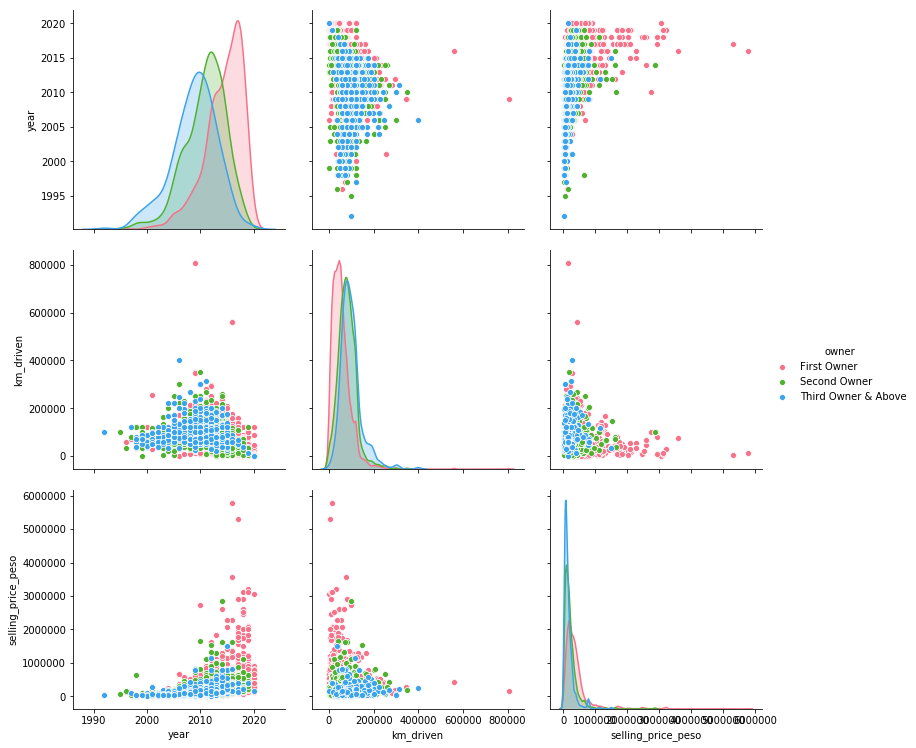

In [20]:
sns.pairplot(df5,hue = 'owner',diag_kind = "kde",kind = "scatter",palette = "husl",height=3.5)
plt.show()

<div style="background-color: #303030;padding: 20px;font-size: 16px;color:white;">
    Cars sold by first owner have higher prices than the rest. Test drive cars tends to have a higher price s as well though there is a distinction between test drive cars in manual and automatic.
</div>

### Year and Kilometer Driven

In [21]:
km_mean = df5.groupby('year')['km_driven'].mean()

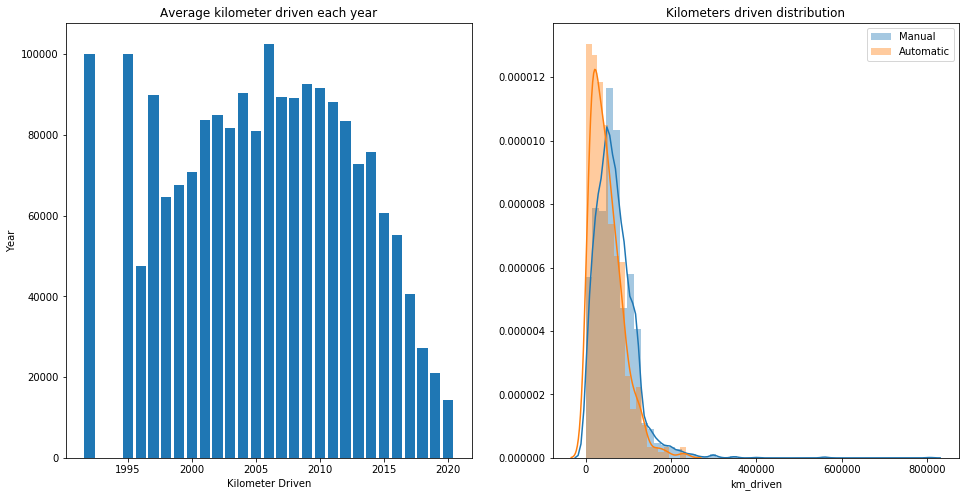

In [22]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(16,8))

ax[0].bar(km_mean.index,km_mean)
sns.distplot(manual['km_driven'],ax=ax[1])
sns.distplot(automatic['km_driven'],ax=ax[1])

ax[0].set_title('Average kilometer driven each year')
ax[0].set_xlabel('Kilometer Driven')
ax[0].set_ylabel('Year')

ax[1].set_title('Kilometers driven distribution')
ax[1].legend(['Manual','Automatic'])

plt.show()

<div style="background-color: #303030;padding: 20px;font-size: 16px;color:white;">
    We can see that average kilometers driven rises up from 1995 until 2005 and linearly goes down until 2020. We can also see some outliers present in the distribution plot.
</div>

### Year and Selling Price

In [23]:
year_mean_manual = df5[df5['transmission']=='Manual'].groupby('year')['selling_price_peso'].mean()
year_mean_automatic = df5[df5['transmission']=='Automatic'].groupby('year')['selling_price_peso'].mean()

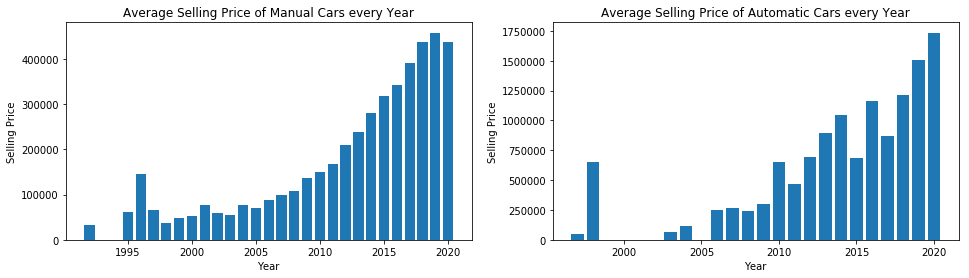

In [24]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))

ax[0].bar(year_mean_manual.index,year_mean_manual)
ax[1].bar(year_mean_automatic.index,year_mean_automatic)

ax[0].set_title('Average Selling Price of Manual Cars every Year')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Selling Price')

ax[1].set_title('Average Selling Price of Automatic Cars every Year')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Selling Price')

plt.show()

<div style="background-color: #303030;padding: 20px;font-size: 16px;color:white;">
    We can see that selling price of manual cars grows linearly each year whereas automatic cars have wavy averages in each year but we can clearly see that selling price grows linearly as well. 
</div>	

### Removing Outliers

In [25]:
df5.groupby('transmission').agg(['mean','std','min','max']).applymap(lambda x: format(x,'.0f')).drop(['year'],axis=1)

km_driven                      selling_price_peso                 \
                  mean    std   min     max               mean     std    min   
transmission                                                                    
Automatic        49771  37676  1100  235000             915654  836074  51350   
Manual           68384  47115     1  806599             258592  180993  13000   

                       
                  max  
transmission           
Automatic     5785000  
Manual        1235000

<div style="background-color: #303030;padding: 20px;font-size: 16px;color:white;">
Clearly we have some outliers present in kilometers driven and selling price. We need to remove these outliers by using IQR method. 
</div>	

In [26]:
def remove_outlier_km_driven(df):
    temp = pd.DataFrame()
    
    df_km_driven = df['km_driven']
    Q1 = df_km_driven.quantile(0.25)
    Q3 = df_km_driven.quantile(0.75)
    IQR = Q3 - Q1
    df_outlier = df_km_driven[(df_km_driven < (Q1 - 1.5 * IQR)) | (df_km_driven > (Q3 + 1.5 * IQR))]
    temp = pd.concat([temp,df_outlier])
        
    return df.drop(temp.index)

df6 = remove_outlier_km_driven(df5)

<div style="background-color: #303030;padding: 20px;font-size: 16px;color:white;">
Removing outliers in selling price would be separated by transmission type and will be done in each year.
</div>	

In [27]:
def remove_outlier_selling_price(df):
    temp = pd.DataFrame()
    for year in sorted(df.year.unique()):
        year_price_manual = df[(df['year']==year) & (df['transmission']=='Manual')]['selling_price_peso']
        manual_Q1 = year_price_manual.quantile(0.25)
        manual_Q3 = year_price_manual.quantile(0.75)
        manual_IQR = manual_Q3 - manual_Q1
        outlier_manual = year_price_manual[(year_price_manual < (manual_Q1 - 1.5 * manual_IQR)) | (year_price_manual > (manual_Q3 + 1.5 * manual_IQR))]
        temp = pd.concat([temp,outlier_manual])
        
        year_price_automatic = df[(df['year']==year) & (df['transmission']=='Automatic')]['selling_price_peso']
        automatic_Q1 = year_price_automatic.quantile(0.25)
        automatic_Q3 = year_price_automatic.quantile(0.75)
        automatic_IQR = automatic_Q3 - automatic_Q1
        outlier_automatic = year_price_automatic[(year_price_automatic < (automatic_Q1 - 1.5 * automatic_IQR)) | (year_price_automatic > (automatic_Q3 + 1.5 * automatic_IQR))]
        temp = pd.concat([temp,outlier_automatic])
    return df.drop(temp.index)

df7 = remove_outlier_selling_price(df6)

In [28]:
year_mean_manual = df7[df7['transmission']=='Manual'].groupby('year')['selling_price_peso'].mean()
year_mean_automatic = df7[df7['transmission']=='Automatic'].groupby('year')['selling_price_peso'].mean()

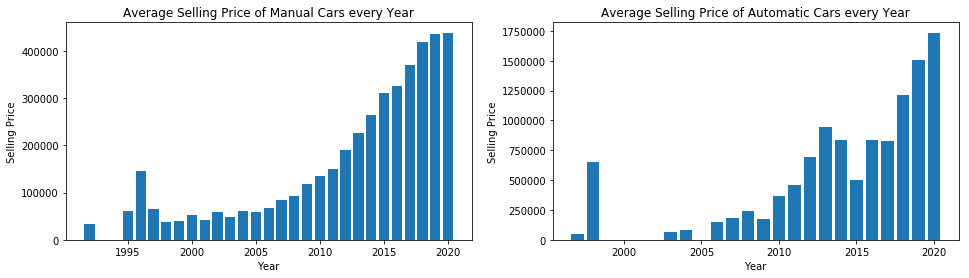

In [29]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))

ax[0].bar(year_mean_manual.index,year_mean_manual)
ax[1].bar(year_mean_automatic.index,year_mean_automatic)

ax[0].set_title('Average Selling Price of Manual Cars every Year')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Selling Price')

ax[1].set_title('Average Selling Price of Automatic Cars every Year')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Selling Price')

plt.show()

In [30]:
# we can also safely remove the datapoints before 2005 since it produces inconsistency and the data points
# below 2000 have low value count
df8 = df7[df7['year']>2005]

In [31]:
year_mean_manual_price = df8[df8['transmission']=='Manual'].groupby('year')['selling_price_peso'].mean()
year_mean_automatic_price = df8[df8['transmission']=='Automatic'].groupby('year')['selling_price_peso'].mean()
year_mean_manual_km = df8[df8['transmission']=='Manual'].groupby('year')['km_driven'].mean()
year_mean_automatic_km = df8[df8['transmission']=='Automatic'].groupby('year')['km_driven'].mean()

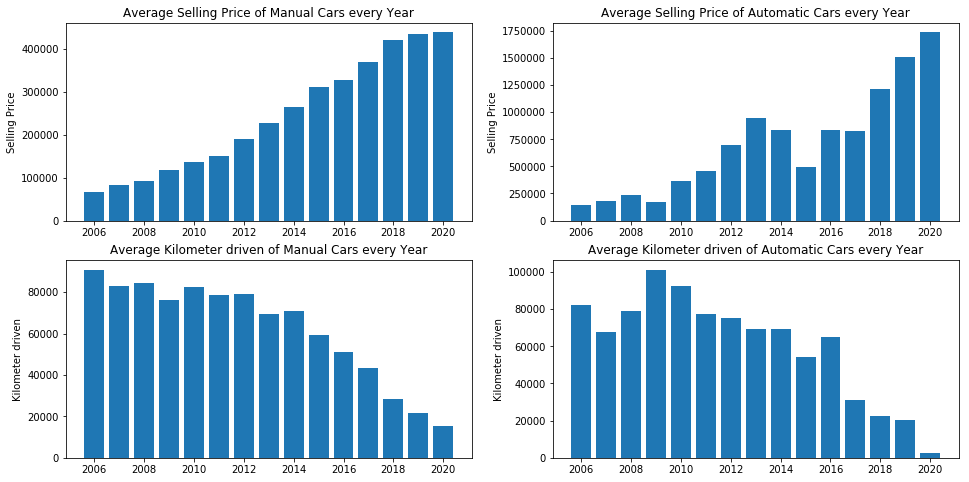

In [32]:
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(16,8))

ax[0][0].bar(year_mean_manual_price.index,year_mean_manual_price)
ax[0][1].bar(year_mean_automatic_price.index,year_mean_automatic_price)

ax[1][0].bar(year_mean_manual_km.index,year_mean_manual_km)
ax[1][1].bar(year_mean_automatic_km.index,year_mean_automatic_km)

ax[0][0].set_title('Average Selling Price of Manual Cars every Year')
ax[0][0].set_ylabel('Selling Price')

ax[0][1].set_title('Average Selling Price of Automatic Cars every Year')
ax[0][1].set_ylabel('Selling Price')

ax[1][0].set_title('Average Kilometer driven of Manual Cars every Year')
ax[1][0].set_ylabel('Kilometer driven')

ax[1][1].set_title('Average Kilometer driven of Automatic Cars every Year')
ax[1][1].set_ylabel('Kilometer driven')

plt.show()

<div style="background-color: #303030;padding: 20px;font-size: 16px;color:white;">
Now we will be removing some suspicious data points. Since the average selling price of cars increases each year whereas average kilometer driven by the car should be atleast lower than the average kilometer driven last year, we will be removing manual and automatic cars which kilometer driven is greater than the average kilometer driven last year but having lower selling price compared to the average price last year.
</div>	

In [33]:
def remove_outlier_last_year(df):
    temp = pd.DataFrame()
    years = sorted(df.year.unique())
    for i in range(1,len(years)):
        df_year = df[(df['year']==years[i])&(df['transmission']=='Manual')]
        last_mean_km_driven = df[(df['year']==years[i-1])&(df['transmission']=='Manual')]['km_driven'].mean()
        last_mean_selling_price = df[(df['year']==years[i-1])&(df['transmission']=='Manual')]['selling_price_peso'].mean() 
        df_outlier = df_year[(df_year['km_driven']>last_mean_km_driven)&(df_year['selling_price_peso']<last_mean_selling_price)]
        temp = pd.concat([temp,df_outlier])
        
        df_year = df[(df['year']==years[i])&(df['transmission']=='Automatic')]
        last_mean_km_driven = df[(df['year']==years[i-1])&(df['transmission']=='Automatic')]['km_driven'].mean()
        last_mean_selling_price = df[(df['year']==years[i-1])&(df['transmission']=='Automatic')]['selling_price_peso'].mean() 
        df_outlier = df_year[(df_year['km_driven']>last_mean_km_driven)&(df_year['selling_price_peso']<last_mean_selling_price)]
        temp = pd.concat([temp,df_outlier]) 
    return df.drop(temp.index)
    
df9 = remove_outlier_last_year(df8)

<div style="background-color: #303030;padding: 20px;font-size: 16px;color:white;">
Now we might also consider removing some inconsistencies in selling price based on number of previous owner. If the second owner offers lower selling price than the average selling price of third owner, we will remove this data points. We will also do this with first and second owners based on year.
</div>	

In [34]:
def remove_outlier_owner(df):
    temp = pd.DataFrame()
    for a in sorted(df.year.unique()):
        for b in ['Manual','Automatic']:
            df_year = df[(df['year']==a)&(df['transmission']==b)]
            second_mean = df_year[df_year['owner']=='Second Owner']['selling_price_peso'].mean()
            third_mean = df_year[df_year['owner']=='Third Owner & Above']['selling_price_peso'].mean()
            df_outlier = df_year[((df_year['owner']=='Second Owner')&(df_year['selling_price_peso']<third_mean)) | ((df_year['owner']=='First Owner')&(df_year['selling_price_peso']<second_mean))]
            temp = pd.concat([temp,df_outlier])
    return df.drop(temp.index)
    
df10 = remove_outlier_owner(df9)

<div style="background-color: #303030;padding: 20px;font-size: 16px;color:white;">
We will also remove data points with low kilometers driven but also having low selling price. We will be removing data points with kilometers driven one standard deviation below the mean and at the same time the selling price below one standard deviation below the mean price. We will be removing data points high kilometers driven and high selling price as well.
</div>	

In [35]:
def remove_outlier_last_year(df):
    temp = pd.DataFrame()
    for i in sorted(df.year.unique()):
        df_year = df[df['year']==i]
        km = df_year['km_driven']
        price = df_year['selling_price_peso']
        outlier = df_year[(df_year['km_driven']<km.mean()-km.std())&(df_year['selling_price_peso']<price.mean()-price.std()) | (df_year['km_driven']>km.mean()+km.std())&(df_year['selling_price_peso']>price.mean()+price.std())]
        temp = pd.concat([temp,outlier])

    return df.drop(temp.index)
    
df11 = remove_outlier_last_year(df10)

<div style="background-color: #303030;padding: 20px;font-size: 16px;color:white;">
    Now we successfully removed outliers.
</div>	

<div style="background-color: #303030;padding: 20px;font-size: 16px;color:white;">
    Now lets see our data in 3d.
</div>	

In [36]:
manual = df11[df11['transmission']=='Manual']
automatic = df11[df11['transmission']=='Automatic']

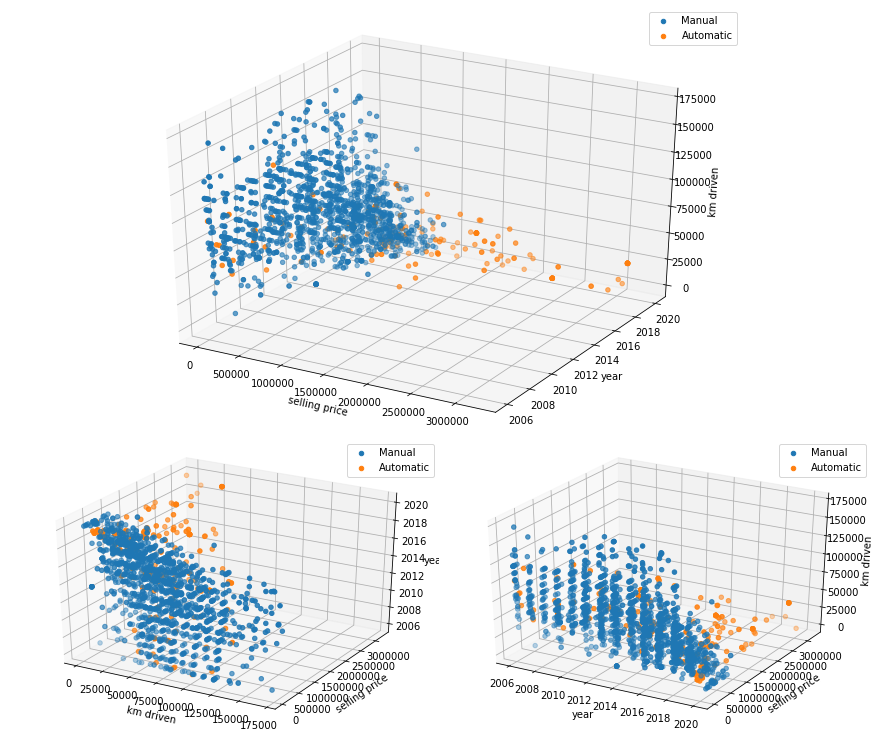

In [37]:
from mpl_toolkits.mplot3d import Axes3D

fig=plt.figure()
ax=fig.add_axes([0.2,0,1.5,1.5], projection='3d')

ax.scatter(manual['selling_price_peso'],manual['year'],manual['km_driven'])
ax.scatter(automatic['selling_price_peso'],automatic['year'],automatic['km_driven'])

ax.set_xlabel('selling price')
ax.set_ylabel('year')
ax.set_zlabel('km driven')

ax.legend(['Manual','Automatic'])

ax=fig.add_axes([0,-1,1,1], projection='3d')

ax.scatter(manual['km_driven'],manual['selling_price_peso'],manual['year'])
ax.scatter(automatic['km_driven'],automatic['selling_price_peso'],automatic['year'])

ax.set_xlabel('km driven')
ax.set_ylabel('selling price')
ax.set_zlabel('year')

ax.legend(['Manual','Automatic'])

ax=fig.add_axes([1,-1,1,1], projection='3d')

ax.scatter(manual['year'],manual['selling_price_peso'],manual['km_driven'])
ax.scatter(automatic['year'],automatic['selling_price_peso'],automatic['km_driven'])

ax.set_xlabel('year')
ax.set_ylabel('selling price')
ax.set_zlabel('km driven')

ax.legend(['Manual','Automatic'])

plt.show()

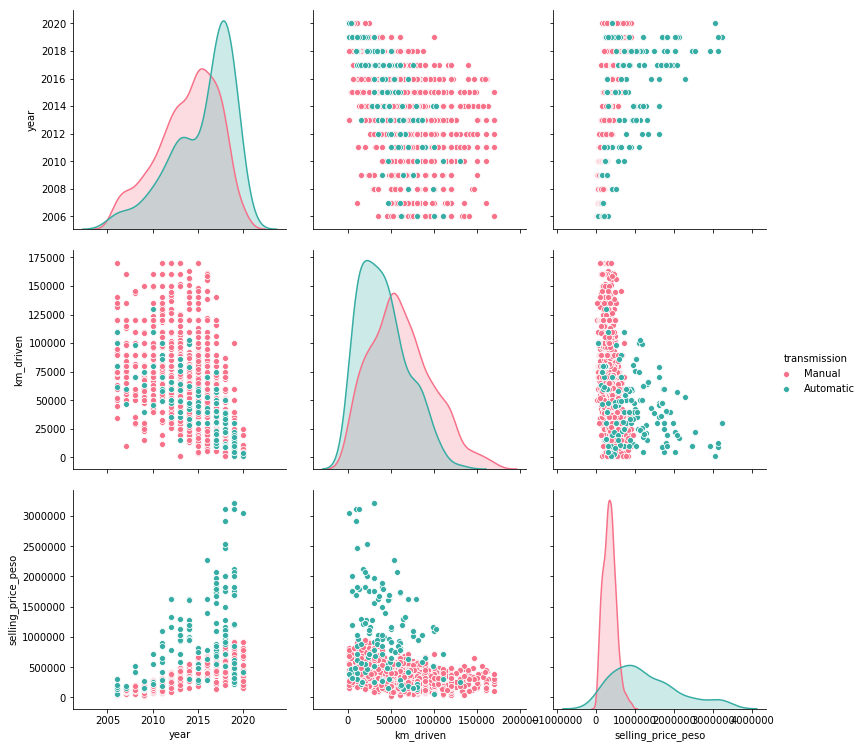

In [38]:
sns.pairplot(df11,hue='transmission',diag_kind = "kde",kind = "scatter",palette = "husl",height=3.5)
plt.show()

<div style="background-color: #303030;padding: 20px;font-size: 16px;color:white;">
    As you can see in the 3d scatter plot, kilometers driven decreases whereas selling price increases over the years. We can also see that automatic cars have higher prices than manual cars. Now it's time to build our model.
</div>	

In [39]:
df11.shape

(1808, 6)

In [166]:
transmission = pd.get_dummies(df11['transmission'])
fuel = pd.get_dummies(df11['fuel'])
owner = df11['owner'].map(lambda x: 1 if x=='First Owner' else 2 if x=='Second Owner' else 3)

X = pd.concat([transmission,fuel,owner,df11.drop(['transmission','fuel','owner','selling_price_peso'],axis=1)],axis=1)
y = df11['selling_price_peso']

In [167]:
X.head(5)

,Automatic,Manual,Diesel,Other,Petrol,owner,year,km_driven
2,0,1,1,0,0,1,2012,100000
4,0,1,1,0,0,2,2014,141000
6,0,1,0,0,1,1,2016,25000
8,0,1,0,0,1,1,2015,25000
12,1,0,0,0,1,1,2018,25000


In [168]:
y.head(5)

2      390000.0
4      292500.0
6      357500.0
8      552500.0
12    1072500.0
Name: selling_price_peso, dtype: float64

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [170]:
lr = LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_test,y_test)

0.6539266868764776

<div style="background-color: #303030;padding: 20px;font-size: 16px;color:white;">
Use K Fold cross validation to measure accuracy of our LinearRegression model.
</div>	

In [171]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.61890108, 0.60390357, 0.54983026, 0.67250382, 0.62429909])

<div style="background-color: #303030;padding: 20px;font-size: 16px;color:white;">
    As you can see, we are getting low score from Linear Regression. Let's see if we can get better results from different regression models.
</div>	

### Find best model using GridSearchCV

In [172]:
def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        },
        'random_forest': {
            'model': RandomForestRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'n_estimators': range(1,50,5)
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

,model,best_score,best_params
0,linear_regression,0.613888,{'normalize': False}
1,lasso,0.613891,"{'alpha': 2, 'selection': 'cyclic'}"
2,decision_tree,0.855054,"{'criterion': 'mse', 'splitter': 'random'}"
3,random_forest,0.864393,"{'criterion': 'mse', 'n_estimators': 26}"


<div style="background-color: #303030;padding: 20px;font-size: 16px;color:white;">
    Based on the results, RandomForestRegressor gives us the best results hence we will use that model. Let's test our model and give it some features.
</div>	

In [184]:
model = RandomForestRegressor(criterion='mse',n_estimators=26)

In [185]:
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=26, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [186]:
def predict_price(transmission,fuel,previous_owner,year,km_driven):
    x = []
    x[:8] = np.zeros(8,dtype='int32')
    x[5] = previous_owner
    x[6] = year
    x[7] = km_driven
    
    transmission_index = np.where(X.columns==transmission)[0][0]
    fuel_index = np.where(X.columns==fuel)[0][0]
    
    if transmission_index>=0:
        x[transmission_index] = 1
    if fuel_index>=2:
        x[fuel_index] = 1
        
    return float(format(model.predict([x])[0],'.2f'))

In [187]:
predict_price('Manual','Diesel',1,2013,10000)

304375.0

In [188]:
predict_price('Automatic','Diesel',1,2015,50000)

653000.0

In [189]:
predict_price('Manual','Diesel',1,2018,20000)

651758.45

In [190]:
predict_price('Manual','Diesel',1,2020,10000)

693061.11

<div style="background-color: #303030;padding: 20px;font-size: 16px;color:white;">
Now we will be exporting our model into a pickle file
</div>

In [191]:
with open('used_car_price_model.pickle','wb') as f:
    pickle.dump(model,f)

In [192]:
# try to load the model
with open('used_car_price_model.pickle','rb') as file:
    mp = pickle.load(file)

In [193]:
# Manual, Diesel, Second Owner, year 2017, 30000 kilometers driven
mp.predict([[0,1,1,0,0,2,2017,30000]])

array([487419.74541667])

In [194]:
columns = {
    "columns": [col for col in X.columns]
}

with open("columns.json","w") as f:
    f.write(json.dumps(columns))